# Data Preparation

In [1]:
import pandas as pd
import os
import re
import csv
from collections import OrderedDict, defaultdict
import random
import torch
from torch.utils import data
from torch.utils.data.dataset import Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_PATH = os.path.expanduser("~/data1/multMyeloma/data/")
EHR_FILENAME = "MMehr_data.csv"

We read the EHR .csv file with the following structure 
```
MEDICAL_RECORD_NUMBER | CODE | CODE_LABEL | AGE_IN_DAYS | TIME_OF_DAY | VALUE | UOM | DAYS | YEAR
```


In [3]:
##Import ehr data of MM patients and conversion table from icd10 to icd9
MMehr_data = pd.read_csv(os.path.join(DATA_PATH, EHR_FILENAME),
                         sep=",",
                         header=0,
                         index_col=False)

We want to combine `CODE` and `CODE_LABEL` in a unique string, e.g. `lab:xxxx`, in order to map the codes to the normalized labels (_RxNorm_).

In [4]:
MMehr_data["LABEL:CODE"] = MMehr_data["CODE_LABEL"] + ':' + MMehr_data["CODE"]

We read the annotation files and create a dictionary of dictionaries `ann_dic` (e.g. {'cpt':{'code':[CUI, ONTOLOGY_ID, LABEL], ...}, ...}). 

In [5]:
ann_dic = {}
for _, _, files in os.walk(DATA_PATH):
    for f in files:
        if re.match('annotation', f):
            with open(os.path.join(DATA_PATH, f), newline='') as csvfile:
                rows = csv.reader(csvfile, delimiter=',', quotechar='"')
                d = {}
                for i, row in enumerate(rows):
                    if i != 0:
                        d[row[0]] = row[1:len(row)]
                ann_dic[f.split('-')[1].split('.')[0]] = d

The codes are mapped to the normalized labels and a new column `RXNORM` is addet to the `MMehr_data` dataframe.

In [6]:
#map the codes to the normalized labels and add a new column to the dataframe
rxnorm = []
for lab_code in MMehr_data["LABEL:CODE"]:
    el = lab_code.split(":")
    if el[1] in ann_dic[el[0]]:
        rxnorm += [ann_dic[el[0]][el[1]][-1]]
    else:
        rxnorm += ['NA']
        

MMehr_data["RXNORM"] = rxnorm

In [7]:
MMehr_data.head(10)

,MEDICAL_RECORD_NUMBER,CODE,CODE_LABEL,AGE_IN_DAYS,TIME_OF_DAY,VALUE,UOM,DAYS,YEAR,LABEL:CODE,RXNORM
0,1000428284,16003,cpt,28150.0,17:28,NaN,NaN,150,2002,cpt:16003,NA
1,1000428284,16007,cpt,28150.0,17:28,NaN,NaN,150,2002,cpt:16007,NA
2,1000428284,16273,cpt,28151.0,15:12,NaN,NaN,151,2002,cpt:16273,"Radiopharmaceutical therapy, by oral administr..."
3,1000428284,22923,procedure,29890.0,17:04,NaN,NaN,64,2007,procedure:22923,Bone survey complete
4,1000428284,22923,procedure,29891.0,09:08,NaN,NaN,65,2007,procedure:22923,Bone survey complete
5,1000428284,16764,cpt,29906.0,13:30,NaN,NaN,80,2007,cpt:16764,Beta-2 microglobulin
6,1000428284,17666,cpt,29906.0,13:30,NaN,NaN,80,2007,cpt:17666,C-reactive protein; high sensitivity (hscrp)
7,1000428284,17711,cpt,29906.0,13:30,NaN,NaN,80,2007,cpt:17711,Immunofixation electrophoresis; serum
8,1000428284,290.21,icd9,30351.0,10:01,NaN,NaN,160,2008,icd9:290.21,Senile dementia with depressive features
9,1000428284,296.32,icd9,30626.0,12:17,NaN,NaN,70,2009,icd9:296.32,"Major depressive affective disorder, recurrent..."


The codes that were not possible to map are removed.

In [8]:
num_rem = MMehr_data.shape[0]

idna = MMehr_data["RXNORM"] == 'NA'
MMehr_data = MMehr_data[-idna]
MMehr_data["RXNORM"] = MMehr_data["CODE_LABEL"] + ':' + MMehr_data["RXNORM"]

print("{0:d} entries were eliminated because it was not possible to map them.".format(num_rem - MMehr_data.shape[0]))

4913542 entries were eliminated because it was not possible to map them.


The `filter_data` method takes as input:

> `df`: a pandas dataframe;

> `col_name`: the column name that is used to select the indices to eliminate;

> `direction`: _greater_ or _smaller_ that indicates the direction w.r.t which we want to filter the data;

> `filt`: the filter value.

In [9]:
def data_filter(df, col_name, direction, filt):
    if direction == 'greater':
        idx = df[col_name] > filt
    else:
        idx = df[col_name] < filt
    return df[-idx]

We eliminate the years which were wrongly set (i.e. greater than the ehr database last year) with `data_filter()`.

In [10]:
MMehr_data = data_filter(MMehr_data, "YEAR", 'greater', 2016)

Now we investigate the distribution of the medical records w.r.t the years they were collected, to see if we need to set a timeframe. We generate a dictionary `year_count` with structure _{year:num}_, ordered by year.

In [11]:
yr_sum = MMehr_data["YEAR"].value_counts()
year_count = yr_sum.to_dict(into=OrderedDict)
year_count = OrderedDict(sorted(year_count.items(), key=lambda t: t[0]))

<BarContainer object of 41 artists>

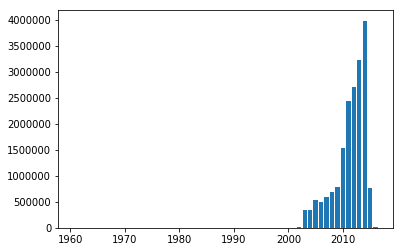

In [12]:
y = [n1 for n1, _ in year_count.items()] 
c = [n2 for _, n2 in year_count.items()]

plt.bar(y, c)

Now we want to investigate the distribution of the lengths of the records for each patients, in this way we can eliminate the patients with too few records. We create a list of lengths.

(array([1.316e+03, 3.980e+02, 2.180e+02, 1.210e+02, 1.010e+02, 9.300e+01,
        1.330e+02, 1.440e+02, 1.040e+02, 8.200e+01, 7.700e+01, 7.200e+01,
        6.700e+01, 5.700e+01, 5.800e+01, 5.100e+01, 4.100e+01, 2.900e+01,
        3.200e+01, 2.800e+01, 3.000e+01, 3.000e+01, 2.700e+01, 2.400e+01,
        2.200e+01, 1.200e+01, 1.700e+01, 2.500e+01, 1.600e+01, 1.300e+01,
        1.500e+01, 1.100e+01, 8.000e+00, 9.000e+00, 1.300e+01, 1.100e+01,
        1.000e+01, 5.000e+00, 1.400e+01, 7.000e+00, 2.000e+00, 6.000e+00,
        5.000e+00, 9.000e+00, 9.000e+00, 7.000e+00, 1.000e+00, 6.000e+00,
        5.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

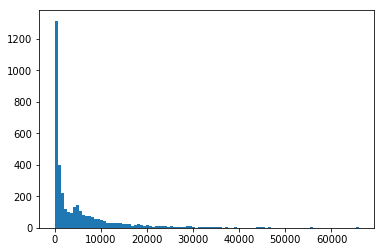

In [13]:
pat_num = MMehr_data["MEDICAL_RECORD_NUMBER"].value_counts()

plt.hist(pat_num, bins=100)

Let's visualize the ehr length distribution selecting only the subjects with at least $k$ entries.

(array([1.221e+03, 3.960e+02, 2.150e+02, 1.220e+02, 9.900e+01, 9.500e+01,
        1.340e+02, 1.410e+02, 1.040e+02, 8.300e+01, 7.600e+01, 7.400e+01,
        6.600e+01, 5.700e+01, 5.800e+01, 5.100e+01, 4.000e+01, 3.000e+01,
        3.100e+01, 2.900e+01, 3.000e+01, 2.900e+01, 2.800e+01, 2.300e+01,
        2.200e+01, 1.200e+01, 1.700e+01, 2.500e+01, 1.600e+01, 1.300e+01,
        1.500e+01, 1.200e+01, 7.000e+00, 9.000e+00, 1.300e+01, 1.100e+01,
        1.000e+01, 5.000e+00, 1.500e+01, 6.000e+00, 2.000e+00, 6.000e+00,
        5.000e+00, 9.000e+00, 9.000e+00, 8.000e+00, 1.000e+00, 5.000e+00,
        5.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 3.000e+00, 4.000e+00,
        2.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 3.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

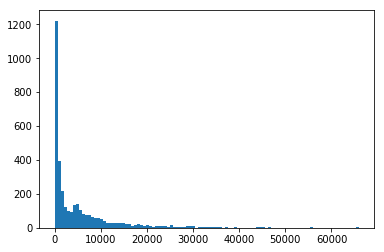

In [14]:
k = 10
fi = pat_num < k
plt.hist(pat_num[-fi], bins=100)

Now we filter the records collected before 1980 with the `data_filter` function.

In [15]:
MMehr_data = data_filter(MMehr_data, "YEAR", 'less', 1980)

Moreover we might want to set the minimum number of records per patient to _k_.

We join the rxnorm terms with their medical term labels. Moreover, we save the resulting dataframe to a new _.csv_ file named `MMehr_normalized`.

In [16]:
rxnorm_codes = MMehr_data["RXNORM"].tolist()
mrn = MMehr_data["MEDICAL_RECORD_NUMBER"].tolist()

In [17]:
days_list = MMehr_data["DAYS"].tolist()
year_list = MMehr_data["YEAR"].tolist()
#Write everything to a csv file with only MEDICAL_RECORD_NUMBER | RXNORM LABEL
with open(os.path.join(DATA_PATH, 'MMehr_normalized.csv'), 'w', newline='') as csvfile:
    normalizedData = csv.writer(csvfile, delimiter=',', quotechar='"')
    normalizedData.writerow(["MRN", "RXNORM", "DAYS", "YEAR"])
    for i in range(len(rxnorm_codes)):
        normalizedData.writerow([mrn[i], rxnorm_codes[i], days_list[i], year_list[i]])

With `create_dict` function we return two dictionaries: `mt_to_ix` and `ix_to_mt` which map rxnorm terms to integers from $1$ to $n$ and viceversa, respectively.

In [18]:
def create_dict(listOfMedTerms): 
    mt_to_ix = {}
    ix_to_mt = {}
    
    for term in listOfMedTerms:
        if term not in mt_to_ix:
            mt_to_ix[term] = len(mt_to_ix) + 1
            ix_to_mt[len(ix_to_mt) + 1] = term
    return mt_to_ix, ix_to_mt

We create the vocabulary for the ehr data.

In [19]:
rxnorm_to_ix, ix_to_rxnorm = create_dict(rxnorm_codes)

We create the dictionary with the ehr sequence for each patient _{mrn:[v1, v2, v3]}_.

In [20]:
patient_dict = OrderedDict()

for idpat in range(len(mrn)):
    if mrn[idpat] in patient_dict:
        patient_dict[mrn[idpat]].append(rxnorm_codes[idpat])
    else:
        patient_dict[mrn[idpat]] = [rxnorm_codes[idpat]]

We now create the list of sentences padding with initial zeros the sentences shorter than the maximum length. The correspondent medical record numbers are reported in the list `mrn_unique`.

In [21]:
max_len = 0
for np in pat_num:
    if np > max_len:
        max_len = np
print(max_len)

65979


In [22]:
patient_sequences = []
mrn_unique = []
for m, sentence in patient_dict.items():
    pad_len = max_len - len(sentence)
    pad = [0] * pad_len
    patient_sequences += [pad + [rxnorm_to_ix[rxnorm_term] for rxnorm_term in sentence]]
    mrn_unique.append(m)

We add $0$ as the `empty` list in the vocabulary.

In [23]:
rxnorm_to_ix['empty'] = 0
ix_to_rxnorm[0] = 'empty'

We save the unique medical records `mrn_unique` and `patient_sequences` to _.csv_ files and the vocabularies to _.csv_ files.

In [91]:
#write to csv file
with open(os.path.join(DATA_PATH, 'rxnorm_to_ix.csv'), 'w') as outfile:
    file = csv.writer(outfile, delimiter=',')
    for key, val in rxnorm_to_ix.items():
        file.writerow([key, val])

with open(os.path.join(DATA_PATH, 'ix_to_rxnorm.csv'), 'w') as outfile:
    file = csv.writer(outfile, delimiter=',')
    for key, val in ix_to_rxnorm.items():
        file.writerow([key, val])
        
with open(os.path.join(DATA_PATH, 'mrn_unique.csv'), 'w', newline='') as outfile:
    file = csv.writer(outfile, delimiter=',', quotechar='"')
    for row in mrn_unique:
        file.writerow([row])

with open(os.path.join(DATA_PATH, 'patient_sequences.csv'), 'w', newline='') as outfile:
    file = csv.writer(outfile, delimiter=',', quotechar='"')
    for row in patient_sequences:
        file.writerow(row)

Function that removes sequences shorter than $k$.

In [25]:
def cut_ehr(med_rec, ehr, k):
    tmp_mrn = []
    tmp_ehr = []
    for i, seq in enumerate(ehr):
        count = 0
        for j in reversed(seq):
            if j > 0:
                count += 1
            else:
                break
        if count > k:
            tmp_mrn.append(med_rec[i])
            tmp_ehr += [seq]
    return tmp_mrn, tmp_ehr

In [26]:
mrn_cut, patient_sequences_cut = cut_ehr(mrn, patient_sequences, 10)

Then we might want to save the cut data to _.csv_ files.

## Dataset and DataLoader
We create two dictionaries, the first stores `{mrn:[patient_sequence]}`, the second is of the form `{'train':[mrns], 'test':[mrns]}`.

In [71]:
import pandas as pd
import os
import re
import csv
from collections import OrderedDict, defaultdict
import random
import numpy as np
import torch
from torch.utils import data
from torch.utils.data.dataset import Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
DATA_PATH = os.path.expanduser("~/data1/multMyeloma/data/")
EHR_FILENAME = "MMehr_data.csv"

In [29]:
with open(os.path.join(DATA_PATH, 'mrn_unique.csv'), 'r', newline='') as f1:
    rows = csv.reader(f1, delimiter=",", quotechar='"')
    mrn_unique = [int(row[0]) for row in rows]

with open(os.path.join(DATA_PATH, 'patient_sequences.csv'), 'r', newline='') as f2:
    rows = csv.reader(f2, delimiter=',', quotechar='"')
    patient_sequences = []
    for row in rows:
        patient_sequences += [[int(row[i]) for i in range(len(row))]]

In [30]:
ehrs = {}

for idp in range(len(mrn_unique)):
    ehrs[mrn_unique[idp]] = patient_sequences[idp]

In [55]:
random.seed(42)
traintest = {'train':[], 'test':[]}
test_idx = random.sample(range(len(mrn_unique)), int(len(mrn_unique) * 0.2))

for i in range(len(mrn_unique)):
    if i in test_idx:
        traintest['test'].append(mrn_unique[i])
    else:
        traintest['train'].append(mrn_unique[i])

In [57]:
class MMdata(Dataset):
    def __init__(self, list_mrn, dic_seq):
        self.list_mrn = list_mrn
        self.dic_seq = dic_seq
        
    def __getitem__(self, index):
        
        mrn_idx = self.list_mrn[index]
        sequence = self.dic_seq[mrn_idx]
        #sequence = torch.tensor(sequence)
        
        #print(type(sequence), type(mrn_idx))
        return sequence, mrn_idx

    def __len__(self):
        return len(self.list_mrn)
    
def my_collate(batch):
    data = [item[0] for item in batch]
    data = torch.tensor(data)
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

In [85]:
# By default, each worker will have its PyTorch seed set to base_seed + worker_id, where base_seed is a long generated by main process using its RNG. 
params = {'batch_size': 32,
          'shuffle': True}
max_epochs = 100

torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
random.seed(12)

training_set, test_set = MMdata(traintest['train'], ehrs), MMdata(traintest['test'], ehrs)
training_generator = data.DataLoader(training_set, **params, collate_fn=my_collate)
test_generator = data.DataLoader(test_set, **params, collate_fn=my_collate)

In [88]:
p = next(iter(test_generator))

In [89]:
print(p[0], p[1])

tensor([[     0,      0,      0,  ...,   2580,   3237,   2580],
        [     0,      0,      0,  ...,    738,   2556,    579],
        [     0,      0,      0,  ...,     44,    108,    108],
        ...,
        [     0,      0,      0,  ...,   1832,    205,    208],
        [     0,      0,      0,  ...,    281,   3006,    108],
        [     0,      0,      0,  ...,     26,    132,    281]]) tensor([ 1.2960e+09,  1.5694e+09,  1.9464e+09,  7.7701e+08,  1.0978e+09,
         3.1720e+09,  3.8463e+09,  3.5606e+09,  2.7958e+08,  2.3297e+09,
         3.7287e+09,  3.0201e+09,  3.6242e+09,  1.5439e+09,  1.2946e+09,
         3.6974e+09,  3.5635e+09,  3.4332e+09,  3.9230e+09,  2.1938e+09,
         3.7101e+09,  3.3482e+09,  2.0676e+09,  2.0571e+09,  2.9856e+09,
         2.0105e+09,  1.3693e+09,  1.6827e+09,  2.5847e+09,  2.6326e+09,
         1.3653e+09,  8.2595e+08])


We have an input of size $(N, 1, T)$, where $N$ is the _batch size_, and $T$ is the length of the ehr sequence for all patients.